# Question: Linear Regression

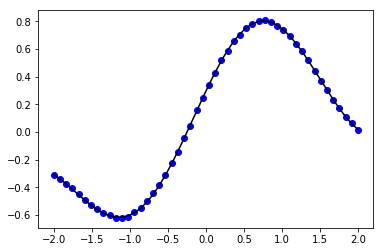

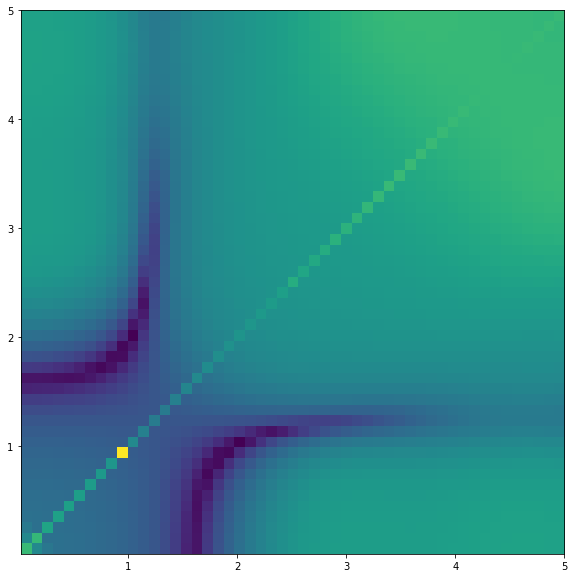

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
from numpy.linalg import LinAlgError

# Number of sine and cosine terms
K = 2
# Number of data points
N = 50
m = 0.2

# For reproducable results
np.random.seed(0)
alpha = 2*np.random.rand(K) - 1
beta = 2*np.random.rand(K) - 1
w = np.arange(1,K+1)
# Lower and upper bounds of the points to be sampled
bounds = [-2, 2]

# The matrix 'A' to be returned from this function consists
# of the features calculated given a 'w' parameter, where 
# upon multiplying by the 'theta' below it will produce
# the estimation for each point corresponding to each row
# of 'A' (returned design matrix).
def make_design_matrix(w, om):
    K = len(w)
    N = len(om)
    A = np.empty((N, 2*K+1))
    for i,x in enumerate(om):
        A[i,0] = x
        A[i, 1:(K+1)] = np.sin(w*x)
        A[i, (K+1):(2*K+1)] = np.cos(w*x)
    return A
# Linear parameters of the model described in the question.
theta = np.concatenate([[m], alpha, beta])
# Evenly sampled input points in 1D space.
x_samples = np.linspace(bounds[0], bounds[1], N)
A = make_design_matrix(w, x_samples)
y = np.dot(A, theta)
# Add reasonably large noise
noise_scale = 0.01
noise_range = (max(y)-min(y))*noise_scale
noises = noise_range*np.random.rand(N) - noise_range/2.0
# Produce noisy random points with the described model.
y_noisy = (y + noises).tolist()


# Relatively tighter sampling of 1D input space in order
# to plot the underlying function of the random points produced.
tight_samples = np.linspace(bounds[0], bounds[1], 10*N)
A_tight = make_design_matrix(w, tight_samples)
plt.plot(x_samples, y_noisy, 'bo', tight_samples, np.dot(A_tight, theta), 'k')
plt.show()


# Tries to take inverse of a square matrix, if fails to
# do so, then it adds a regularizer term then takes inverse.
def safe_inverse(matrix, regularizer = 0.0001):
    try:
        inverse = np.linalg.inv(matrix)
    except LinAlgError:
        inverse = np.linalg.inv(matrix+np.identity(len(matrix))*regularizer)
    return inverse
# Search over a range of values for 'w' parameters
# in an exhaustive manner.
OM = np.linspace(0.01,5,51)
# Best values of the linear parameters, given a
# pair of 'w' parameters, are used to calculate the
# error values (surface).
EE = np.zeros((len(OM),len(OM)))
actual_values = y_noisy
for i,omega1 in enumerate(OM):
    for j,omega2 in enumerate(OM):
        A = make_design_matrix(np.array([omega1, omega2]), x_samples)
        A_t = np.transpose(A)
        estimated_theta = np.dot( np.dot( safe_inverse(np.dot(A_t, A)), A_t ), actual_values )
        estimated_values = np.dot(A, estimated_theta)
        EE[i, j] = sum((actual_values - estimated_values)**2)
min_index = np.unravel_index(EE.argmin(), EE.shape)
# Find the pair of 'w' parameters with least amount of error.
best_w = [OM[min_index[0]], OM[min_index[1]]]

# These lines are for plotting purposes
l = min(OM); r = max(OM);
plt.figure(figsize=(10,10))
plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
plt.show()


# Question: Stochastic Gradient Descent

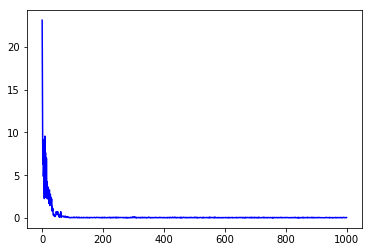

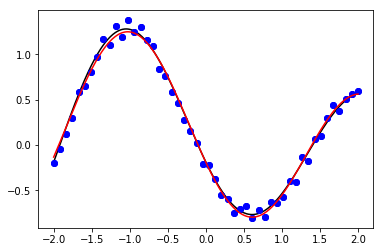

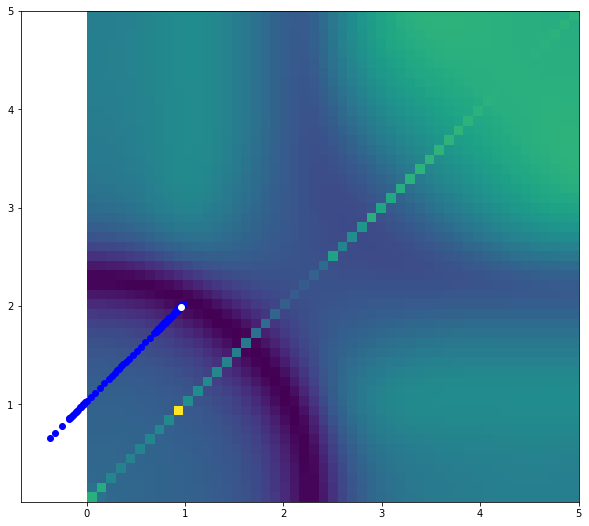

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
from numpy.linalg import LinAlgError


K = 2
N = 50
m = 0.2

#np.random.seed(0)
alpha = 2*np.random.rand(K) - 1
beta = 2*np.random.rand(K) - 1
w = np.arange(1,K+1)
bounds = [-2, 2]

def make_design_matrix(w, om):
    K = len(w)
    N = len(om)
    A = np.empty((N, 2*K+1))
    for i,x in enumerate(om):
        A[i,0] = x
        A[i, 1:(K+1)] = np.sin(w*x)
        A[i, (K+1):(2*K+1)] = np.cos(w*x)
    return A
theta = np.concatenate([[m], alpha, beta])
x_samples = np.linspace(bounds[0], bounds[1], N)
A = make_design_matrix(w, x_samples)
y = np.dot(A, theta)
# Add reasonably large noise
noise_scale = 0.1
noise_range = (max(y)-min(y))*noise_scale
noises = noise_range*np.random.rand(N) - noise_range/2.0
y_noisy = (y + noises)

# Assume 'x' is scalar!!!
def f(m, alpha, beta, w, x):
    return m*x+np.dot(alpha, np.sin(w*x))+np.dot(beta, np.cos(w*x))

def error_gradient(m, alpha, beta, w, x, y):
    K = len(w)
    x_len = len(x)
    gradient = np.zeros((3*K+1))
    err = 0
    for i, x_i in enumerate(x):
        e_i = y[i] - f(m, alpha, beta, w, x_i)
        err += e_i**2
        factor = -e_i/x_len
        gradient[0] += x_i*factor
        np_sin = np.sin(w*x_i)
        gradient[1:(K+1)] += np_sin*factor
        np_cos = np.cos(w*x_i)
        gradient[(K+1):(2*K+1)] += np_cos*factor
        gradient[(2*K+1):(3*K+1)] += (np.dot(alpha, np_cos*x_i) - np.dot(beta, np_sin*x_i))*factor
    return (gradient, err)

def SGD(x, y, K, batch_scale=2e-1, MAX_EPOCH=1000, learning_rate = 5e-2,
        momentum = 9e-1, decay_rate = 0.95, epsilon = 1e-4):
    N = len(x)
    batch_size = round(batch_scale*N)
    if batch_size == 0: batch_size = 1
    parameters = 2*np.random.rand(3*K + 1) - 1
    grad = np.zeros((3*K+1))
    ERR = []
    w_history = []
    for epoch in range(MAX_EPOCH):
        idx = np.random.choice(N, batch_size, replace=False)
        x_sample = x[idx]
        y_sample = y[idx]
        mom = momentum*grad
        grad, err = error_gradient(parameters[0], parameters[1:(K+1)],
                              parameters[(K+1):(2*K+1)], parameters[(2*K+1):(3*K+1)],
                              x_sample, y_sample)
        grad += mom
        parameters += learning_rate*(-grad)
        ERR.append(err)
        w_history.append(np.copy(parameters[(2*K+1):(3*K+1)]))
        #learning_rate *= decay_rate
        #momentum *= decay_rate
        #if max(grad) < epsilon: break
    return (parameters, grad, ERR, w_history)

parameters, grad_last, ERR, w_history = SGD(x_samples, y_noisy, K)
tight_samples = np.linspace(bounds[0], bounds[1], 10*N)
A_est = make_design_matrix(parameters[(2*K+1):(3*K+1)], tight_samples)

plt.figure(1)
plt.plot(ERR, 'b')

plt.figure(2)
A_tight = make_design_matrix(w, tight_samples)
plt.plot(x_samples, y_noisy, 'bo', tight_samples, np.dot(A_tight, theta), 'k')
plt.plot(x_samples, y_noisy, 'bo', tight_samples, np.dot(A_est, parameters[0:(2*K+1)]), 'r')

def safe_inverse(matrix, regularizer = 0.0001):
    try:
        inverse = np.linalg.inv(matrix)
    except LinAlgError:
        inverse = np.linalg.inv(matrix+np.identity(len(matrix))*regularizer)
    return inverse
OM = np.linspace(0.01,5,51)
EE = np.zeros((len(OM),len(OM)))
actual_values = y_noisy
for i,omega1 in enumerate(OM):
    for j,omega2 in enumerate(OM):
        A = make_design_matrix(np.array([omega1, omega2]), x_samples)
        A_t = np.transpose(A)
        estimated_theta = np.dot( np.dot( safe_inverse(np.dot(A_t, A)), A_t ), actual_values )
        estimated_values = np.dot(A, estimated_theta)
        EE[i, j] = sum((actual_values - estimated_values)**2)
min_index = np.unravel_index(EE.argmin(), EE.shape)
best_w = [OM[min_index[0]], OM[min_index[1]]]

# These lines are for plotting purposes
l = min(OM); r = max(OM);
plt.figure(figsize=(10,10))
plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
plt.scatter(x=[w[0] for w in w_history[:-1]], y=[w[1] for w in w_history[:-1]], c='b')
plt.scatter(x=w_history[-1][0], y=w_history[-1][1], c='w', )
plt.show()



# Question 3: Decision Trees

In [10]:
import pandas as pd
import scipy as sc
from sklearn.datasets import load_iris
import numpy as np
import math
import matplotlib.pyplot as plt    


Plots the given data with given clas vector. 

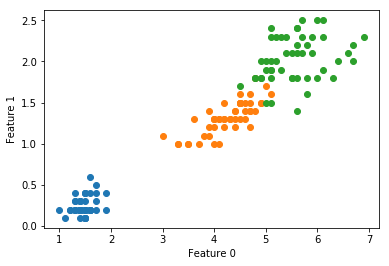

In [11]:
def scat_data(X,c):
    X=X[:,0:2]
    num_of_labels=len(np.unique(c))
    for x in range(num_of_labels):
        ss=c==x
        plt.plot(X[ss,0],X[ss,1],"o")
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.show()

dataset = load_iris()


X, c = dataset['data'][:,2:], dataset['target']
scat_data(X,c)

Calculates entropy, gini and information gain indices and plots them for both features of the data. X is the dataset, c is the class vector and n is the feature number(calculating indices for which feature). 

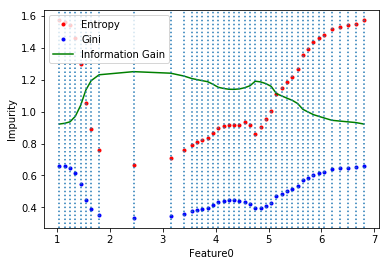

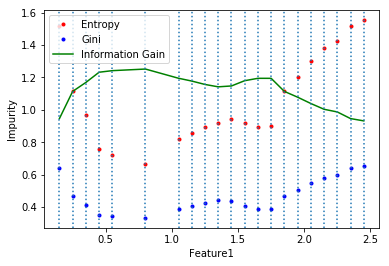

In [12]:
def entropy(X,c,n):
    
    #Calculates the entropy of the given probabilities of classes. 
    #Both right and left of the data should be send.
    def ent_of_data(data):
        length=len(data)
        _,occurrences=np.unique(data, return_counts=True)
        e=0
        for occ in occurrences:
           p=occ/(length*1.0)
           e+=p*math.log(p,2)
        return -e
    
    #Calculates the gini indis, the frequency of a class is divided by the 
    #total number of data and the squares of the results are added up.
    #The final result is subtracted from 1 and sent.
    def gini(data):
        length=len(data)
        _,occurrences=np.unique(data, return_counts=True)
        g=0
        for occ in occurrences:
           p=occ/(length*1.0)
           g+=p*p
        return 1-g 

    f=np.zeros(X.shape)
    f[:,0]=X[:,n]
    f[:,1]=c
    f=f[f[:,0].argsort()]
    ent=[]
    gin=[]
    ig=[]
    uf=np.unique(f[:,0])
    
    #The threshold is set to middles of the following two points. Then for each threshold
    #the indices are calculated.
    boundries=np.convolve(uf,np.array([0.5,0.5]),mode='valid')
    for tau in boundries:
        idx,=np.where(f[:,0]<tau)
        l=len(idx)/(len(c)*1.0)
        idx=idx[-1]  
        L=ent_of_data(f[:,1][:idx+1])*l
        R=ent_of_data(f[:,1][idx+1:])*(1.0-l)
        ent.append(L+R)
        
        L=gini(f[:,1][:idx+1])*l
        R=gini(f[:,1][idx+1:])*(1.0-l)
        gin.append(L+R)
        
        ig.append(ent_of_data(f[:,1])-(L+R))
    
    #Plots the corresponding indices for feature n. 
    plt.xlabel('Feature'+str(n))
    plt.ylabel('Impurity')
    plt.plot(boundries,ent,".r")
    plt.plot(boundries,gin,".b")
    plt.plot(boundries,ig,"g")
    plt.legend(["Entropy","Gini","Information Gain"])
    for b in boundries:
        plt.axvline(b,ls=":")
    plt.show()
    
#Both feature 0 and 1 is sent for the entropy, gini and information gain scores.
entropy(X,c,0)  
entropy(X,c,1)

# Question 4: ROC curve and the AUC score

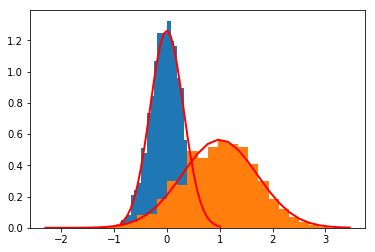

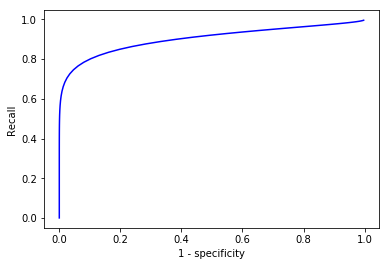

AUC SCORE for Gaussian distribution: 0.8985122534942827


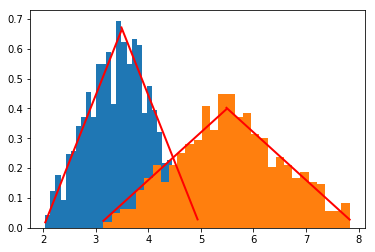

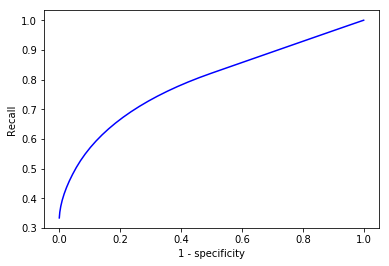

AUC SCORE for Symmetric triangular distribution: 0.7912795861399617


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import quad

plot_number = 1

def gaussian(mu, sigma):
    """
    You can give any variance and mean value.
    """
    s = np.random.normal(mu, sigma, 1000)
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins,integrand_of_gaussion(bins,sigma,mu) ,
                linewidth=2, color='r')
    return integrand_of_gaussion,bins


def integrand_of_gaussion(bins,sigma,mu):
        return 1/(sigma * np.sqrt(2 * np.pi)) * \
                    np.exp( - (bins - mu)**2 / (2 * sigma**2))                    


def plot_curves_of_gaussians(mu1, v1, mu2, v2):
    global plot_number
    sigma1=math.sqrt(v1)    
    sigma2=math.sqrt(v2)
    plt.figure(plot_number); plot_number += 1
    f0,bins0=gaussian(mu1,sigma1)
    f1,bins1=gaussian(mu2,sigma2)
    plt.show()
    lb = min(bins0)
    ub = max(bins1)
    ts=np.linspace(lb,ub,100)

    fpr=[]
    tpr=[]

    for t in ts:
        v0,_=quad(integrand_of_gaussion,t,math.inf, args=(sigma1,mu1))
        fpr.append(v0)
        v1,_=quad(integrand_of_gaussion,t,math.inf, args=(sigma2,mu2))
        tpr.append(v1)
    
    plt.figure(plot_number); plot_number += 1
    plt.plot(fpr,tpr,"b")
    plt.xlabel('1 - specificity')
    plt.ylabel('Recall')
    plt.show()
    
    tpr.reverse()
    fpr.reverse()
    auc=np.trapz(tpr, fpr)
    print("AUC SCORE for Gaussian distribution: "+str(auc))
    
    
plot_curves_of_gaussians(0,0.1,1,0.5)
    
                    
def triangular(a,c,b):
    s= np.random.triangular(a, c, b, 1000)
    count, bins, ignored = plt.hist(s,30,normed=30)
    x=int(len(bins)/2)
    plt.plot(bins[:x+1],integrand_of_triangular1(bins[:x+1],a,c,b),linewidth=2, color='r')
    plt.plot(bins[x:],integrand_of_triangular2(bins[x:],a,c,b),linewidth=2, color='r')
    return bins

    
def integrand_of_triangular1(x,a,c,b):
        return 2*(x-a)/((b-a)*(c-a)*1.0)
    
    
def integrand_of_triangular2(x,a,c,b):
        return 2*(b-x)/((b-a)*(b-c)*1.0)
    
    
def plot_curves_of_triangulars(a0,b0,a1,b1):    
    global plot_number
    c0=(a0+b0)/2.0
    c1=(a1+b1)/2.0
    plt.figure(plot_number); plot_number += 1
    bins0=triangular(a0,c0,b0)
    bins1=triangular(a1,c1,b1)
    lb = min(bins0)
    ub = max(bins1)
    
    ts=np.linspace(lb,ub,100)
    ub=ts[len(ts)-1]
    
    
    plt.show()
    

    fpr=[]
    tpr=[]

    for t in ts:
        if a0<=t and t<=c0:
            v0_1,_=quad(integrand_of_triangular1,t,c0, args=(a0,c0,b0))
            v0_2,_=quad(integrand_of_triangular2,c0,b0, args=(a0,c0,b0))
            v0=v0_1+v0_2
            fpr.append(v0)
        elif t>c0 and t<=b0:
            v0,_=quad(integrand_of_triangular2,t,b0, args=(a0,c0,b0))
            fpr.append(v0)
            
            
        if a1<=t and t<=c1:
            v1_1,_=quad(integrand_of_triangular1,t,c1, args=(a1,c1,b1))
            v1_2,_=quad(integrand_of_triangular2,c1,b1, args=(a1,c1,b1))
            v1=v1_1+v1_2
            tpr.append(v1)
        elif t>c1 and t<=b1:
            v1,_=quad(integrand_of_triangular2,t,b1, args=(a1,c1,b1))
            tpr.append(v1)
       
    smallest=min(len(fpr),len(tpr))
    
    fpr=fpr[:smallest]
    tpr=tpr[:smallest]
    
    plt.figure(plot_number); plot_number += 1
    plt.plot(fpr,tpr,"b")
    plt.xlabel('1 - specificity')
    plt.ylabel('Recall')
    plt.show()
    
    
    tpr.reverse()
    fpr.reverse()
    auc=np.trapz(tpr, fpr)
    print("AUC SCORE for Symmetric triangular distribution: "+str(auc))
    

plot_curves_of_triangulars(2,5,3,8)